**ส่วนนี้คือการ load ข้อมูล, การทำ data cleaning, และการกำจัด outliers (ท่านสามารถดูเพิ่มเติมได้ที่ 1_Data_Cleaning.ipynb)**

**สำหรับ Linear Regression จะเริ่มต่อท้ายหลังจบส่วนนี้**

In [1]:
import sys
sys.version

'3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]'

In [2]:
# disable warnings that are not critical for a clean looking
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
df = pd.read_csv('./dataset/listings.csv',
                 usecols=['neighbourhood_group_cleansed',
                          'room_type','accommodates',
                          'bathrooms_text','beds','price',
                          'minimum_nights','maximum_nights'])

In [5]:
df['bathrooms_text'].replace('Half-bath','0.5 baths', inplace=True)
df['bathrooms_text'].replace('Shared half-bath','0.5 shared baths', inplace=True)
df['bathrooms_text'].replace('Private half-bath','0.5 baths', inplace=True)

In [6]:
df.dropna(subset=['bathrooms_text'], inplace=True)

In [7]:
df['baths'] = df['bathrooms_text'].apply(lambda x: x.split(' ')[0])

In [8]:
df['baths'] = df['baths'].astype(float)

In [9]:
df.drop(['bathrooms_text'],axis=1,inplace=True)

In [10]:
df['beds'].fillna(value=1, inplace=True)

In [11]:
df['beds'] = df['beds'].astype(int)

In [12]:
# Remove dollar and comma signs from price column
df['price'].replace({'\$':'', ',':''}, regex = True, inplace=True)

# Convert string to float
df['price'] = df['price'].astype(float)

#### การกำจัด outliers

In [13]:
df_real = df.copy()

In [14]:
def my_func(a, b, c, val):
    tmp = df_real[(df_real[a]==b) & (df_real[c] >= val)]
    df_real.drop(index=tmp.index, inplace=True)

In [15]:
my_func('neighbourhood_group_cleansed','Manhattan','price',423)
my_func('neighbourhood_group_cleansed','Brooklyn','price',307)
my_func('neighbourhood_group_cleansed','Queens','price',237)
my_func('neighbourhood_group_cleansed','Staten Island','price',217)
my_func('neighbourhood_group_cleansed','Bronx','price',222)

In [16]:
my_func('room_type','Entire home/apt','price',335)
my_func('room_type','Private room','price',164)
my_func('room_type','Hotel room','price',402)
my_func('room_type','Shared room','price',143)

**Linear Regression จะเริ่มต้นขึ้นต่อจากนี้**

---

# Linear Regression

## Feature Selection

เลือกเฉพาะตัวแปรที่จะนำมาใช้ในการฝึกสอน model ได้แก่ เมืองของห้องพัก, ประเภทของห้อง, จำนวนแขกที่รองรับได้, จำนวนเตียง, และจำนวนห้องน้ำ

In [17]:
df_real.drop([
    'minimum_nights',
    'maximum_nights',
],axis=1, inplace=True)

In [18]:
df_real.columns

Index(['neighbourhood_group_cleansed', 'room_type', 'accommodates', 'beds',
       'price', 'baths'],
      dtype='object')

## สร้าง dummy variables

สร้าง dummy variables โดย drop_first ด้วย เพื่อป้องกันปัญหา multi-collinearity (การมีสหสัมพันธ์กันเองระหว่างตัวแปรอิสระ) ซึ่งจะทำให้ model มีความคลาดเคลื่อนได้:

In [19]:
df_real = pd.get_dummies(df_real, drop_first=True)
# drop_first=True in order to prevent the Multi-collinearity problem

In [20]:
#df_real.sample(5)

In [21]:
X = df_real.drop(['price'], axis=1)

y = np.array(df_real['price']).reshape(-1,1)
# Reshape a serie into 1 column array before feed it into the algorithm

## ทำการแบ่งข้อมูล train/test ด้วยอัตราส่วน 80:20

ทำการแบ่งข้อมูลเป็นสองชุด ได้แก่

1) Training Set เพื่อใช้ฝึกสอน model
2) Test Set เพื่อใช้ประเมิน model

นั่นคือ จะใช้ข้อมูลชุด Training Set ในขณะฝึกสอน model และ model จะไม่เคยเห็นข้อมูลชุด Test Set มาก่อน นี่ทำให้เราสามารถประเมิน model ได้อิงกับความเป็นจริงมากกว่า

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

Linerar Regression ไม่จำเป็นต้องทำ Data Scaling (Standardisation) เพราะใช้การปรับ (fit) เส้น Regression กับจุดข้อมูล  

แต่ Support Vector Regression (SVR) ควรทำ Data Scaling (Standardisation) เพราะถ้าจุดข้อมูลของแต่ละตัวแปรอิสระมี scale ที่ต่างกันเกินไป จะทำให้อัลกอริทึมวัดระยะห่างของแต่ละจุดข้อมูลได้ยาก ส่งผลให้ model ทำการ fit hyperplane ได้ยากและไม่ดีเท่าที่ควร

In [23]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

## แสดงค่าจุดตัดแกนและค่าสัมประสิทธิ์ของ Linear Regression

ค่าจุดตัดแกนของ model:

In [24]:
print('Intercept =',lm.intercept_[0])

Intercept = 88.13867510509206


ค่าสัมประสิทธิ์ของ model:

In [25]:
pd.DataFrame(lm.coef_, 
             index = ['Slope'], 
             columns = X.columns).T

,Slope
accommodates,9.913310
beds,0.706539
baths,6.591963
neighbourhood_group_cleansed_Brooklyn,17.896464
neighbourhood_group_cleansed_Manhattan,42.692114
neighbourhood_group_cleansed_Queens,3.590093
neighbourhood_group_cleansed_Staten Island,-4.706540
room_type_Hotel room,64.175654
room_type_Private room,-65.911291
room_type_Shared room,-81.433965


ตัวอย่างการแปลผล slope หรือสัมประสิทธิ์ ในพหุนามของ Linear Regression ที่เพิ่งสร้างเสร็จ:
- จำนวนแขกที่รองรับที่เพิ่มขึ้น 1 คน ทำให้ค่าเช่าเพิ่ม 9.913310 USD
- จำนวนเตียงที่เพิ่มขึ้น 1 เตียง ทำให้ค่าเช่าเพิ่ม 0.706539 USD
- จำนวนห้องน้ำที่เพิ่มขึ้น 1 ห้อง ทำให้ค่าเช่าเพิ่ม 6.591963 USD
- ถ้าห้องพักมาจากเมือง Brooklyn ทำให้ค่าเช่าเพิ่ม 17.896464 USD
- เป็นต้น

## การประเมิน model ที่ใช้ทำนาย

นำ model ที่เพิ่งสร้างเสร็จมาทำนายกับชุดข้อมูล Test Set:

In [26]:
predicted = lm.predict(X_test)

In [27]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predicted))
print('MSE:', metrics.mean_squared_error(y_test, predicted))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

MAE: 34.551230059976895
MSE: 2109.9436859629036
RMSE: 45.93412332855503


ค่า Root Mean Square Error (RMSE) บ่งบอกถึงผลต่างระหว่างค่าจริงกับค่าทำนาย ยิ่งต่ำยิ่งบ่งบอกว่า model fit กับชุดข้อมูลได้ดี model นี้มีค่า RMSE เท่ากับ 45.93 USD

In [28]:
from sklearn.metrics import r2_score

print('R2:', r2_score(y_test, predicted))

R2: 0.5194046323766995


ค่า R-squared บ่งบอกว่า model fit กับชุดข้อมูลได้ดีเพียงใด มีค่าตั้งแต่ 0 ถึง 1 โดย 0 หมายถึงแย่ที่สุด และ 1 หมายถึงดีที่สุด model นี้มีค่า R-squared เท่ากับ 0.52 ถือว่าอยู่ในระดับปานกลาง

**(สามารถดูการเปรียบเทียบประสิทธิภาพระหว่าง Linear Regression และ Support Vector Regression (SVR) ได้ที่ 6_Comparison.ipynb)**

In [29]:
# Save evaluation results for use in the Performance Graph Comparison
RMSE_LR = np.sqrt(metrics.mean_squared_error(y_test, predicted))
R2_LR = r2_score(y_test, predicted)

np.savetxt('./eval_results/RMSE_LR.txt', [RMSE_LR])
np.savetxt('./eval_results/R2_LR.txt', [R2_LR])

## กราฟแจกแจงความถี่ของผลต่างระหว่างค่าจริง (Test) กับค่าทำนาย (Predict)

In [30]:
diff = y_test-predicted

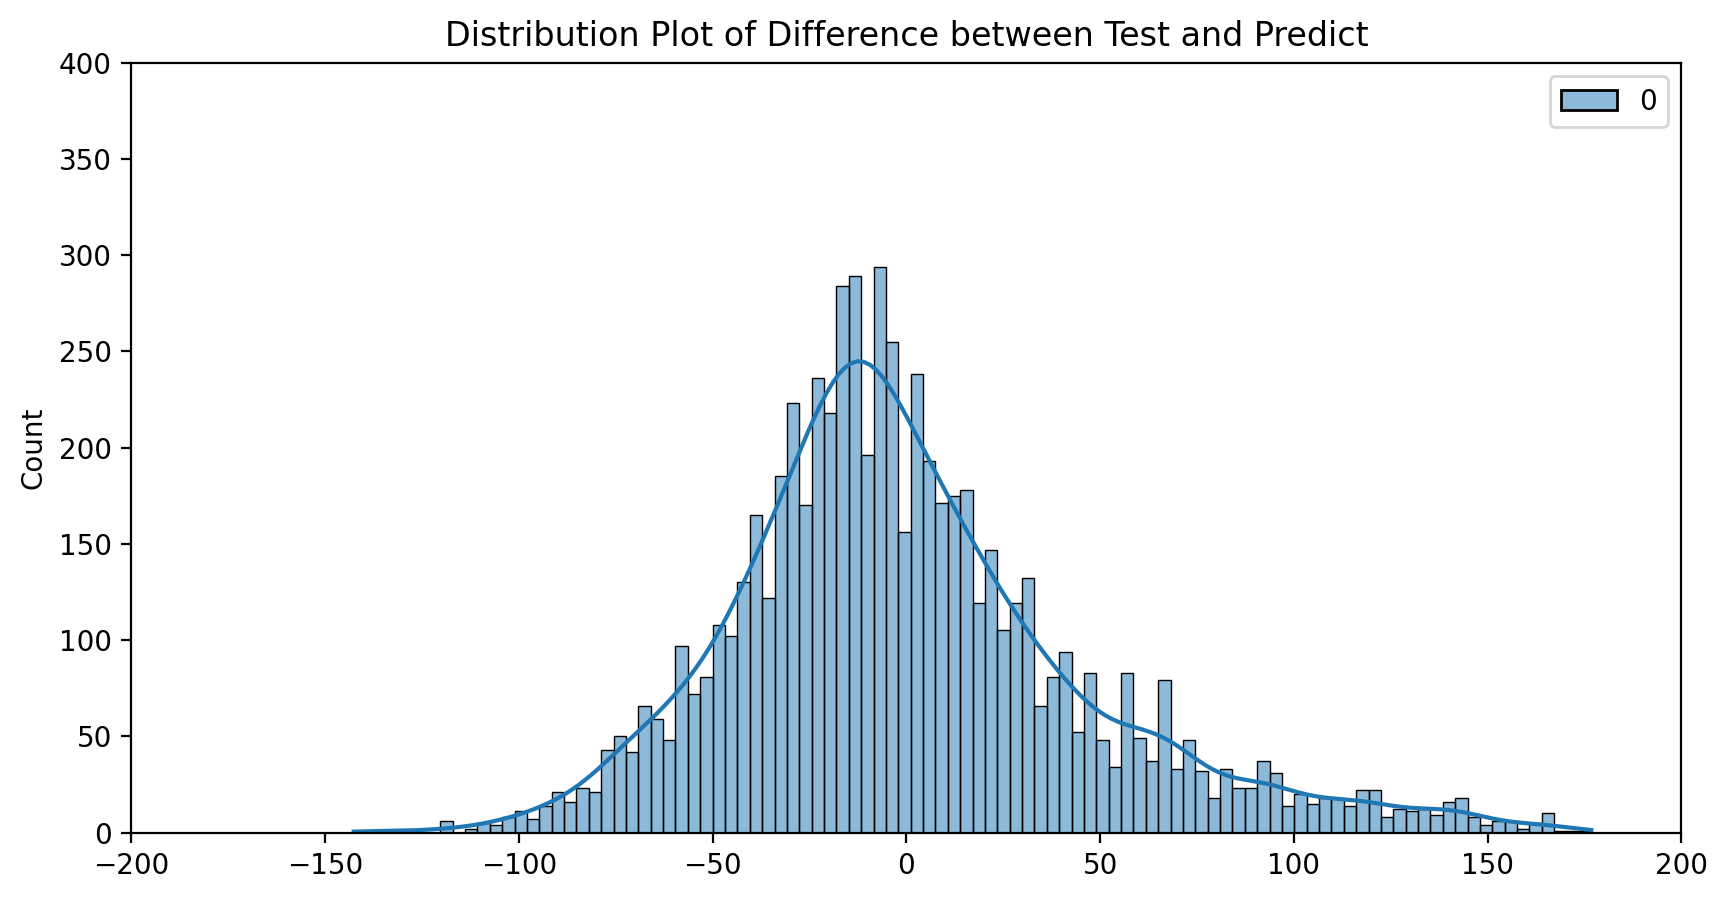

In [31]:
fig = plt.figure(figsize=(10,5))
sns.histplot(diff,bins=100, kde=True)
plt.xlim([-200,200])
plt.ylim([0,400])
plt.title('Distribution Plot of Difference between Test and Predict')

plt.show()

In [32]:
print('S.D. =', diff.std())
print('Mean =', diff.mean())

S.D. = 45.93376090413296
Mean = 0.18246962719755033


**จากกราฟพบว่า:**
1) ได้กราฟที่ใกล้เคียงการแจกแจงแบบปกติ (normal distribution) และเบ้ขวา (Right Skew) เล็กน้อย (ข้อมูลหนักไปทางซ้ายเล็กน้อย)
2) ผลต่างระหว่างค่าจริงกับค่าทำนาย มีส่วนเบี่ยงเบนมาตรฐาน (S.D.) เท่ากับ 45.93 USD นั่นคือ ผลต่างระหว่างค่าจริงกับค่าทำนายส่วนใหญ่ค่อนข้างอยู่ใกล้ค่าเฉลี่ย 0.18 USD ซึ่งค่าเฉลี่ยใกล้กับ 0 USD มาก

## เปรียบเทียบราคาจริงกับราคาที่ได้จากการทำนาย

In [33]:
dict_compare = {'Price': y_test.flatten(), 'predicted':  predicted.flatten()}
df_predicted = pd.DataFrame(dict_compare)

In [34]:
df_predicted.sample(5)

,Price,predicted
3691,217.0,158.662452
5131,125.0,143.073573
3855,220.0,157.955912
705,253.0,178.489072
6547,50.0,57.335661


In [35]:
#print(df_predicted.to_string())

หาค่าสหสัมพันธ์ระหว่างราคาจริง (test) กับราคาที่ได้จากการทำนาย (predicted):

In [36]:
df_predicted.corr()

,Price,predicted
Price,1.000000,0.720752
predicted,0.720752,1.000000


ค่าสหสัมพันธ์ระหว่างราคาจริงกับราคาที่ได้จากการทำนายเท่ากับ 0.72  
นั่นคือ ราคาจริงกับราคาที่ได้จากการทำนายไปในทิศทางเดียวกันพอสมควร

## ทดลองใช้ model ทำนาย

แสดง columns ของตัวแปรอิสระ เพื่อให้สร้าง DataFrame สำหรับป้อนเข้า model ให้มีเรียงลำดับของตัวแปรอิสระอย่างถูกต้อง

In [37]:
X.columns

Index(['accommodates', 'beds', 'baths',
       'neighbourhood_group_cleansed_Brooklyn',
       'neighbourhood_group_cleansed_Manhattan',
       'neighbourhood_group_cleansed_Queens',
       'neighbourhood_group_cleansed_Staten Island', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')

**ยกตัวอย่าง:**  

ต้องการทำนายว่าจากตัวแปรดังต่อไปนี้

- จำนวนแขกที่รองรับได้: 3 คน
- จำนวนเตียง: 2 เตียง
- จำนวนห้องน้ำ: 2 ห้อง
- เมืองของห้องพัก: Manhattan
- ประเภทของห้อง: เช่าทั้งหลัง

ควรจะมีราคาค่าเช่าเท่าไร?

สร้าง DataFrame สำหรับป้อนเข้า model เพื่อทำนาย:

In [38]:
tmp = pd.DataFrame([[3,2,2,0,1,0,0,0,0,0]], 
                   columns=df_real.drop(['price'], axis=1).columns)
tmp

,accommodates,beds,baths,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,3,2,2,0,1,0,0,0,0,0


In [39]:
lm.predict(tmp)

array([[175.16772491]])

**การทำนาย:**

Linear Regression ทำนายว่าควรจะมีราคาค่าเช่า 175.17 USD

## (Optional) Load/Save model